# Bar data

In [1]:
from ib_insync import *
util.startLoop()

ib = IB()
ib.connect('127.0.0.1', 7497, clientId=14)

<IB connected to 127.0.0.1:7497 clientId=14>

## Historical data

To get the earliest date of available bar data the "head timestamp" can be requested:

In [2]:
contract = Stock('TSLA', 'SMART', 'USD')

ib.reqHeadTimeStamp(contract, whatToShow='TRADES', useRTH=True)

datetime.datetime(2010, 6, 29, 8, 0)

To request hourly data of the last 60 trading days:

In [3]:
bars = ib.reqHistoricalData(
        contract,
        endDateTime='',
        durationStr='60 D',
        barSizeSetting='1 hour',
        whatToShow='TRADES',
        useRTH=True,
        formatDate=1)

In [4]:
bars[0]

BarData(date=datetime.datetime(2017, 7, 18, 15, 30), open=317.41, high=323.25, low=315.66, close=321.97, volume=11250, barCount=5895, average=319.677)

Convert the list of bars to a data frame and print the first and last rows:

In [5]:
df = util.df(bars)

display(df.head())
display(df.tail())

,date,open,high,low,close,volume,barCount,average
0,2017-07-18 15:30:00,317.41,323.25,315.66,321.97,11250,5895,319.677
1,2017-07-18 16:00:00,322.07,325.73,321.02,325.62,12538,6059,324.088
2,2017-07-18 17:00:00,325.55,325.62,322.70,323.25,5014,2587,323.960
3,2017-07-18 18:00:00,323.22,324.35,322.65,323.89,3257,1666,323.575
4,2017-07-18 19:00:00,323.96,327.28,323.56,326.81,4764,2262,325.709


,date,open,high,low,close,volume,barCount,average
415,2017-10-10 17:00:00,350.00,350.05,347.11,347.95,4325,2198,348.238
416,2017-10-10 18:00:00,348.00,349.64,346.99,349.44,3408,1811,348.279
417,2017-10-10 19:00:00,349.44,354.35,349.43,353.75,8777,4212,351.851
418,2017-10-10 20:00:00,353.85,354.65,351.81,353.65,6532,3341,353.381
419,2017-10-10 21:00:00,353.71,355.63,352.77,355.60,9553,6094,354.515


Instruct the notebook to draw plot graphics inline:

In [6]:
%matplotlib inline

Plot the close data

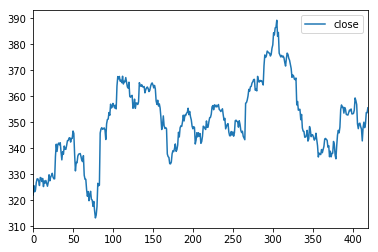

In [7]:
df.plot(y='close');

There is also a utility function to plot bars as a candlestick plot. It can accept either a DataFrame or a list of bars. Here it will print the last 100 bars:

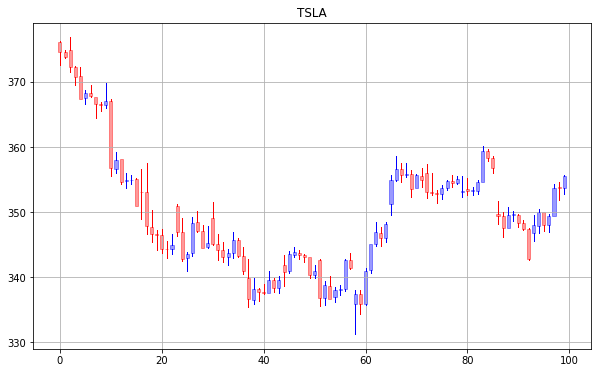

In [8]:
util.barplot(bars[-100:], title=contract.symbol);

## Historical data with realtime updates

A new feature of the API is to get live updates for historical bars. This is done by setting `endDateTime` to an empty string and the `keepUpToDate` parameter to `True`.

Let's get some bars with an keepUpToDate subscription:

In [9]:
contract = Forex('EURUSD')

bars = ib.reqHistoricalData(
        contract,
        endDateTime='',
        durationStr='900 S',
        barSizeSetting='10 secs',
        whatToShow='MIDPOINT',
        useRTH=True,
        formatDate=1,
        keepUpToDate=True)

Replot for every change of the last bar:

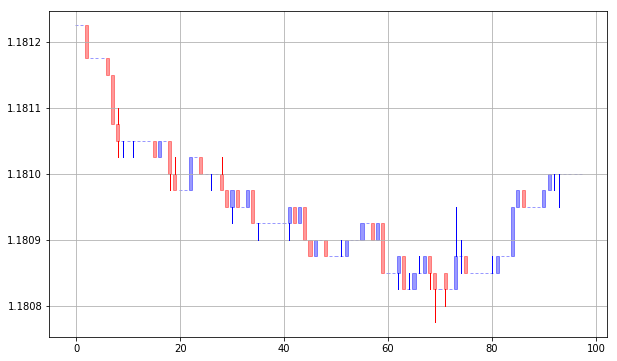

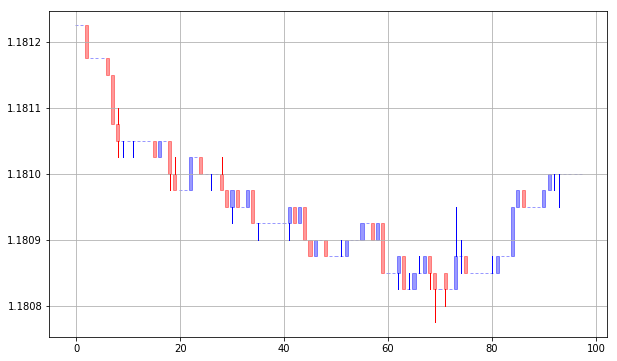

ERROR:ib_insync.wrapper:Error 162, reqId 4: Historical Market Data Service error message:API historical data query cancelled: 4


In [10]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

def onBarUpdate(bars, hasNewBar):
    plt.close()
    plot = util.barplot(bars)
    clear_output(wait=True)
    display(plot)

ib.setCallback('barUpdate', onBarUpdate)
ib.sleep(60)
ib.cancelHistoricalData(bars)

Realtime bars
------------------

With ``reqRealTimeBars`` a subscription is started that sends a new bar every 5 seconds.

First we'll set up a callback for bar updates:

In [11]:
def onBarUpdate(bars, hasNewBar):
    print(bars[-1])

ib.setCallback('barUpdate', onBarUpdate)

Then do the real request,

In [12]:
bars = ib.reqRealTimeBars(contract, 5, 'MIDPOINT', False)

let it run for half a minute and then cancel the realtime bars.

In [13]:
ib.sleep(30)
ib.cancelRealTimeBars(bars)

RealTimeBar(time=datetime.datetime(2017, 10, 10, 23, 19, 15), open=1.181, high=1.181, low=1.181, close=1.181, volume=-1, wap=-1.0, count=-1)
RealTimeBar(time=datetime.datetime(2017, 10, 10, 23, 19, 20), open=1.181, high=1.181, low=1.180975, close=1.180975, volume=-1, wap=-1.0, count=-1)
RealTimeBar(time=datetime.datetime(2017, 10, 10, 23, 19, 25), open=1.180975, high=1.180975, low=1.180975, close=1.180975, volume=-1, wap=-1.0, count=-1)
RealTimeBar(time=datetime.datetime(2017, 10, 10, 23, 19, 30), open=1.180975, high=1.180975, low=1.180975, close=1.180975, volume=-1, wap=-1.0, count=-1)
RealTimeBar(time=datetime.datetime(2017, 10, 10, 23, 19, 35), open=1.180975, high=1.180975, low=1.180975, close=1.180975, volume=-1, wap=-1.0, count=-1)
RealTimeBar(time=datetime.datetime(2017, 10, 10, 23, 19, 40), open=1.180975, high=1.180975, low=1.180975, close=1.180975, volume=-1, wap=-1.0, count=-1)
RealTimeBar(time=datetime.datetime(2017, 10, 10, 23, 19, 45), open=1.180975, high=1.181, low=1.18097

The advantage of reqRealTimeBars is that it behaves more robust when the connection to the IB server farms is interrupted. After the connection is restored, the bars from during the network outage will be backfilled and the live bars will resume.

reqHistoricalData + keepUpToDate will, at the moment of writing, leave the whole API inoperable after a network interruption.

In [14]:
ib.disconnect()